# Summary
This code trains and evaluates a Random Forest Classifier to predict deforestation events based on land use and tree cover data. The input data consists of a stack of raster files, including land use plans, tree cover, and historical deforestation data. The model uses these raster files to predict deforestation events for the year 2012.

The input raster data is flattened and stacked into a single 2D array, X_flat. `NoData` values are removed from the input data (X_cleaned) and the target variable (y_cleaned) before splitting them into training and testing datasets.

The Random Forest Classifier is trained using the X_train and y_train datasets, and its performance is evaluated using cross-validation. The trained model is then used to predict deforestation events for the testing dataset (X_test). The model's performance is assessed using confusion matrices and classification reports for both the training and testing datasets.

Finally, the feature importances of the input variables (e.g., land use plans, tree cover) are calculated and visualized in a bar chart to understand the relative importance of each input variable in predicting deforestation events.

# Import Libraries and Constants

In [13]:
import os
import re
import sys
import numpy as np
import tempfile
import shutil
import matplotlib.pyplot as plt
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score


In [14]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)



In [15]:
from constants import SERVER_PATH, OUTPUT_PATH, MASKED_RASTERS_DIR


In [16]:
# Constants

# Current working folder
input_folder =  os.path.join(MASKED_RASTERS_DIR[0], 'lup_year_grupo_raster','lup_11_grupo_raster')

#output
output_folder = os.path.join(OUTPUT_PATH[0], 'using_grupo_rf_model')
#for mask
no_data_value = -1
# for mask and stack
lup_raster_pattern = re.compile(r'^lup_\d+_grupo_raster\.tif$')



# Create Stack

In [17]:
# helper function to read tiff files
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)


In [18]:
#get the year of the folder
folder_name = os.path.basename(input_folder)
year = folder_name.split('_')[1]
year

'11'

In [19]:
# Read all the raster files in the folder
all_files = [
    file for file in os.listdir(input_folder)
    if file.endswith(".tif") and not lup_raster_pattern.match(file)
]

# Get deforestation file names and sort by year
deforestation_pattern = re.compile(r'^deforestation_(\d+)_masked\.tif$')
deforestation_files = sorted(
    [file for file in all_files if deforestation_pattern.match(file)],
    key=lambda x: int(deforestation_pattern.match(x).group(1))
)

raster_files = []
treecover_file = "tree_cover_10_percent_and_above_masked.tif"





### lup_file requires UPDATE

In [21]:
lup_file = f"lup_{year}_grupo_raster_masked.tif"



In [23]:
raster_files += [
        os.path.join(input_folder, treecover_file),
        os.path.join(input_folder, lup_file)
    ]



for deforestation_file in deforestation_files: 
    # Get corresponding raster files
    raster_files += [
        os.path.join(input_folder, deforestation_file)  
    ]



raster_data_arrays = [read_tiff_image(file_path) for file_path in raster_files]
raster_data_flat = [data_array.flatten() for data_array in raster_data_arrays]


In [29]:
# Find the dimensions of all the raster data arrays
raster_shapes = [raster_data.shape for raster_data in raster_data_arrays]

# Check if all raster data arrays have the same dimensions
if len(set(raster_shapes)) > 1:
    print("There are mismatching dimensions:")
    for file_path, raster_shape in zip(raster_files, raster_shapes):
        print(f"File: {file_path}, Shape: {raster_shape}")
else:
    print("All raster data arrays have the same dimensions.")
    # Check the dimensions of all the raster data arrays
    for i, data_array in enumerate(raster_data_arrays):
        print(f"Raster {i}: {data_array.shape}")


All raster data arrays have the same dimensions.
Raster 0: (22512, 20381)
Raster 1: (22512, 20381)
Raster 2: (22512, 20381)
Raster 3: (22512, 20381)
Raster 4: (22512, 20381)
Raster 5: (22512, 20381)
Raster 6: (22512, 20381)
Raster 7: (22512, 20381)
Raster 8: (22512, 20381)
Raster 9: (22512, 20381)
Raster 10: (22512, 20381)
Raster 11: (22512, 20381)
Raster 12: (22512, 20381)


# Target Variable
Here we want to find the next years deforestation file from the next folder

In [26]:
def find_deforestation_file(folder_path, current_year):
    next_year = int(current_year) + 1
    for file in os.listdir(folder_path):
        if file.endswith(".tif") and file.startswith(f"deforestation_{next_year}_"):
            return os.path.join(folder_path, file)
    return None



current_folder = input_folder

# Get the list of all folders in the lup_year_grupo_raster folder
lup_year_grupo_raster_folder = os.path.dirname(current_folder)
all_folders = [os.path.join(lup_year_grupo_raster_folder, f) for f in os.listdir(lup_year_grupo_raster_folder) if os.path.isdir(os.path.join(lup_year_grupo_raster_folder, f))]

# Sort the folders
all_folders.sort()

# Find the index of the current folder in the list of all folders
current_folder_index = all_folders.index(current_folder)

# Check if the current folder is the last folder
if current_folder_index == len(all_folders) - 1:
    print("The current folder is the last folder. No more folders to process.")
else:
    # Get the path to the next folder
    next_folder = all_folders[current_folder_index + 1]

    # Find the deforestation file in the next folder
    y_file = find_deforestation_file(next_folder, year)
    print("Next folder:", next_folder)
    print("Deforestation file:", y_file)



Next folder: /Users/romero61/../../capstone/pyforest/ml_data/output/masked_rasters/lup_year_grupo_raster/lup_12_grupo_raster
Deforestation file: /Users/romero61/../../capstone/pyforest/ml_data/output/masked_rasters/lup_year_grupo_raster/lup_12_grupo_raster/deforestation_12_masked.tif


In [31]:
#Add the 2012 deforestation file to the raster_files list:
raster_files += [
    y_file
]
# Read the raster data for the additional file
raster_data_arrays.append(read_tiff_image(y_file))

# Flatten the raster data for the additional file
raster_data_flat.append(raster_data_arrays[-1].flatten())

In [32]:
# Stack the flattened raster data
X_flat = np.column_stack(raster_data_flat)

# Use the y_file obtained from the find_deforestation_file function
y = read_tiff_image(y_file).flatten()

# Remove rows with NoData values
'''checks each row in X_flat and creates a boolean array (valid_rows_X) that has the same number of elements 
as the number of rows in X_flat. Each element in valid_rows_X is True if there is no NoData value in 
the corresponding row of X_flat and False otherwise.'''
valid_rows_X = ~(X_flat == no_data_value).any(axis=1)

'''checks each element in the y array and creates a boolean array (valid_rows_y) that has the same number of 
elements as y. Each element in valid_rows_y is True if the corresponding element in y is not 
equal to the NoData value and False otherwise.'''
valid_rows_y = y != no_data_value

'''checks each element in the y array and creates a boolean array (valid_rows_y) 
that has the same number of elements as y. Each element in valid_rows_y is True if the corresponding element 
in y is not equal to the NoData value and False otherwise.'''
valid_rows = valid_rows_X & valid_rows_y

'''creates a new array X_cleaned by selecting only the rows in X_flat that 
correspond to the True elements in valid_rows.'''
X_cleaned = X_flat[valid_rows]

'''creates a new array y_cleaned by selecting only the elements in y that correspond 
to the True elements in valid_rows.'''
y_cleaned = y[valid_rows]


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)




In [6]:
# Train the Random Forest Classifier
params = {
    "n_estimators": 200,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "max_depth": None,
    "bootstrap": False,
}
clf = RandomForestClassifier(random_state=0, verbose=1, n_jobs=19, **params)


In [7]:

# Perform cross-validation
cv_scores = cross_val_score(clf, X_cleaned, y_cleaned, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))



The model is predicting probabilities. The RandomForestClassifier, by default, outputs probabilities of class membership. It provides the probability of each pixel belonging to the deforested or non-deforested class. However, when you use clf.predict(), it returns the class with the highest probability, which is a binary result (deforested or non-deforested).

 The clf.predict_proba() function obtains probabilities instead of the binary result returning probabilities of each class. ` y_proba = clf.predict_proba(X_cleaned)[:, 1] `extracts the probabilities of deforestation events (class 1) for all pixels.
. 

In [ ]:
'''Trains RandomForestClassifier using clf.fit(X_train, y_train), 
then evaluating the classifier on the training set and 
the test set by calculating the confusion matrix and classification report.''' 

clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred_train = clf.predict(X_train)
train_cm = confusion_matrix(y_train, y_pred_train)
train_cr = classification_report(y_train, y_pred_train)
print("Training confusion matrix:")
print(train_cm)
print("Training classification report:")
print(train_cr)

y_pred_test = clf.predict(X_test)
test_cm = confusion_matrix(y_test, y_pred_test)
test_cr = classification_report(y_test, y_pred_test)
print("Testing confusion matrix:")
print(test_cm)
print("Testing classification report:")
print(test_cr)

# Calculate feature importances and the standard deviation for those importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# Predict probabilities for deforestation events
y_proba = clf.predict_proba(X_cleaned)[:, 1]


# Predicts the probabilities for deforestation
# Create a probability raster by filling in the valid pixel values
prob_raster = np.full(y.shape, no_data_value, dtype=np.float32)
prob_raster[valid_rows] = y_proba
prob_raster = prob_raster.reshape(deforestation_11_data_array.shape)



# This raster represents the predicted deforestation probabilities for each pixel in the 2012 raster.

In [9]:
# Save the probability raster as a GeoTIFF file
output_dir = "/Users/romero61/github/PYFOREST-ML/src/data_loading/outputs/using_grupo_raster"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_file = os.path.join(output_dir, "deforestation_prob.tiff")

with rasterio.open(grupo_data) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

prob_raster_reshaped = prob_raster.reshape((1, prob_raster.shape[0], prob_raster.shape[1]))

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write_band(1, prob_raster_reshaped[0])




/tmp/ipykernel_2867438/3696878984.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')


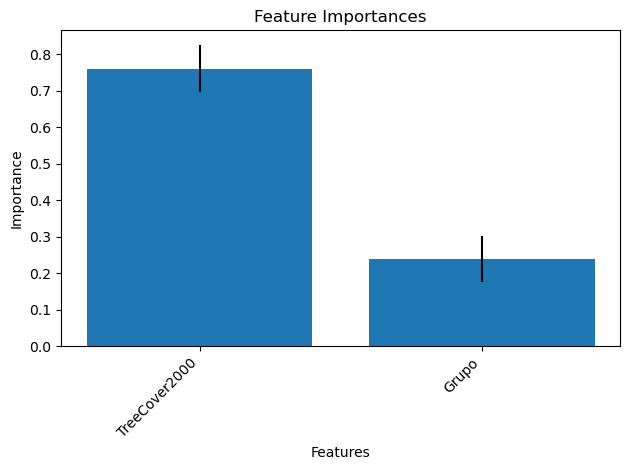

In [10]:

 # list of feature names corresponding to the input bands of your raster stack
feature_names = ['Grupo', 'TreeCover2000']
# Create a sorted list of tuples containing feature names and their importances:
sorted_features = sorted(zip(feature_names, importances, std), key=lambda x: x[1], reverse=True)

# Create a bar chart
fig, ax = plt.subplots()

# Set the feature names as x-axis labels
ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')
ax.set_xticks(range(len(sorted_features)))

# Set the y-axis labels as importances
ax.bar(range(len(sorted_features)), [item[1] for item in sorted_features], yerr=[item[2] for item in sorted_features])

# Set the title and labels for the chart
ax.set_title('Feature Importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')

# Display the chart
plt.tight_layout()
plt.show()
